# MMC Laboratorium 6

Autor: Jakub Ostrzołek

## Zadanie 1

### Funkcje ładujące wyniki działania programu `epidemia`

In [240]:
import numpy as np
from dataclasses import dataclass
from typing import TextIO
from pathlib import Path

BINARY = "./out/ising"

FILENAMES = {
    "final_map": "mapa.txt",
    "susceptible": "podatni_kazdego_dnia.txt",
    "infectious": "chorzy_kazdego_dnia.txt",
    "recovered": "ozdrowiali_kazdego_dnia.txt"
}


def load_stats(file: TextIO) -> np.ndarray:
    return np.array([line.split() for line in file.readlines()], dtype=int)


@dataclass
class Sequence:
    data: np.ndarray

    def lim_percentile(self, percentile: float):
        """5-ty percentyl z wartości pod koniec symulacji"""
        return np.percentile([row[-1] for row in self.data], percentile)


@dataclass
class ExperimentResult:
    final_map: np.ndarray
    susceptible: Sequence
    infectious: Sequence
    recovered: Sequence

        

def load_experiment_results(directory: str) -> ExperimentResult:
    dir = Path(directory)
    def load_field(filename: str):
        with open(dir / filename) as f: return load_stats(f)

    data = {field: load_field(filename) for field, filename in FILENAMES.items()}
    return ExperimentResult(
        final_map=data["final_map"],
        susceptible=Sequence(data["susceptible"]),
        infectious=Sequence(data["infectious"]),
        recovered=Sequence(data["recovered"]),
    )

### Funkcja uruchamiająca program `epidemia`

Zmodyfikowałem program `epidemia` tak, żeby przyjmował swoje parametry poprzez argumenty wywołania linii poleceń.

In [241]:
from subprocess import run
from tempfile import TemporaryDirectory

def run_experiment(
        side: int = 200,
        infectious_n: int = 20,
        injected_n: int = 60,
        beta: float = 0.5,
        gamma: float = 0.25,
        experiment_n: int = 20,
        day_n: int = 200,
    ) -> ExperimentResult:
    command = [
        Path(BINARY).absolute(),
        "--bok-mapy", str(side),
        "--chorzy-dnia-zero", str(infectious_n),
        "--zaszczepieni-dnia-zero", str(injected_n),
        "--beta", str(beta),
        "--gamma", str(gamma),
        "--ile-eksperymentow", str(experiment_n),
        "--ile-dni", str(day_n),
    ]

    with TemporaryDirectory() as temp_dir:
        print(f"temporary directory: {temp_dir}")
        process = run(command, cwd=temp_dir)
        process.check_returncode()

        return load_experiment_results(temp_dir)

### Wywołanie programu z domyślnymi parametrami

In [242]:
result = run_experiment()

temporary directory: /tmp/tmpq0r_dgum
Eksperyment 1/20


Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/20
Eksperyment 18/20
Eksperyment 19/20
Eksperyment 20/20


Podsumowanie ostatniego z 20 eksperymentów Monte Carlo
  Szczyt zachorowań przypada na dzień 37
  Liczba zarażonych w szczycie to 3515 (8% populacji)
  Liczba zarażonych przekraczała 5% populacji przez 37 dni
  Liczba zarażonych utrzymuje się poniżej 5% populacji od dnia 147


### Funkcje wizualizacji wyników działania programu `epidemia`

Funkcja `show_map` wyświetla mapę końcowego rozkładu osób o odpowiednich statusach.

Funkcja `show_sequences` wyświetla jedną ze statystyk czasowych przebiegu eksperymentu, poprzez wykreślenie linii dla każdego eksperymentu w ramach serii. Oprócz tego zaznacza linią przerywaną 5-ty percentyl wartości statystyki z końca przebiegów eksperymentów w serii.

In [267]:
from matplotlib import pyplot as plt
from matplotlib import colormaps

def show_map(map: np.ndarray, title: str | None = None):
    plt.figure(figsize=(6.4, 6.4))
    ax = plt.subplot(1, 1, 1)
    cax = ax.imshow(map)
    cbar = plt.colorbar(cax, ticks=[0, 1, 2, 3], orientation="horizontal")
    cbar.ax.set_xticklabels(["zaszczepiony", "ozdrowiały", "podatny", "chory"])
    if title:
        plt.title(title)
    plt.show()


def show_sequences(
    sequences: list[Sequence],
    sequence_labels: list[str] | None = None,
    title: str | None = None,
    ylabel: str | None = None,
    percentile: float = 0.05,
):
    should_draw_legend = True
    if sequence_labels is None:
        sequence_labels = [None for _ in sequences]
        should_draw_legend = False
    sequence_labels: list[str]


    n_sets = len(sequences)
    colors = [colormaps["hsv"](i/n_sets) for i in range(n_sets)]

    for sequence, label, color in zip(sequences, sequence_labels, colors):
        _, xn = sequence.data.shape
        xs = np.array(range(xn))
        for i, row in enumerate(sequence.data):
            if i != 0:
                label = None
            plt.plot(xs, row, color=color, label=label, linewidth=1)
        plt.xlabel("Dzień")
        
        y_lim = sequence.lim_percentile(percentile)
        plt.hlines(y_lim, xs[0], xs[-1], color=color, linestyles="--")

    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if should_draw_legend:
        plt.legend(loc="best")
    
    plt.show()

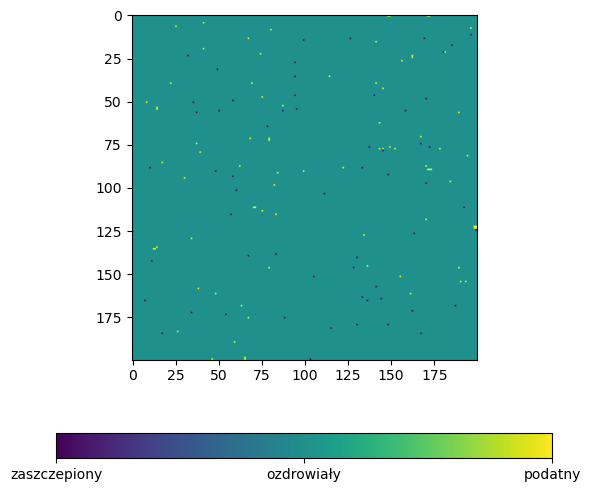

In [263]:
show_map(result.final_map)

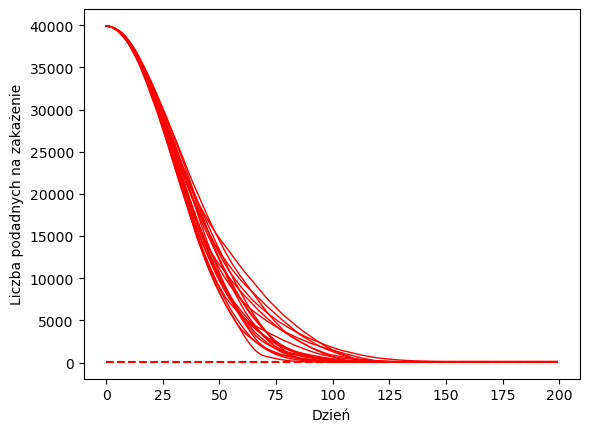

In [245]:
show_sequences([result.susceptible], ylabel="Liczba podadnych na zakażenie")

### Uruchomienie eksperymentu dla różnych początkowych liczb zaszczepionych osób $N_Z$

In [256]:
SIDE = 200
N = SIDE**2
BETA = 0.5
GAMMA = 0.25
INFECTIOUS_N = 20
EXPERIMENT_N = 20
DAY_N = 200


injected_ns = [N // 20, N // 10, N // 8, N // 5, N // 4]

results = [
    run_experiment(
        side=SIDE,
        infectious_n=INFECTIOUS_N,
        injected_n=injected_n,
        beta=BETA,
        gamma=GAMMA,
        experiment_n=EXPERIMENT_N,
        day_n=DAY_N,
    )
    for injected_n in injected_ns
]

temporary directory: /tmp/tmpboktpwcq
Eksperyment 1/20
Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/20
Eksperyment 18/20
Eksperyment 19/20
Eksperyment 20/20


Podsumowanie ostatniego z 20 eksperymentów Monte Carlo
  Szczyt zachorowań przypada na dzień 30
  Liczba zarażonych w szczycie to 2431 (6% populacji)
  Liczba zarażonych przekraczała 5% populacji przez 35 dni
  Liczba zarażonych utrzymuje się poniżej 5% populacji od dnia 142
temporary directory: /tmp/tmpow5hg5ih
Eksperyment 1/20
Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/2

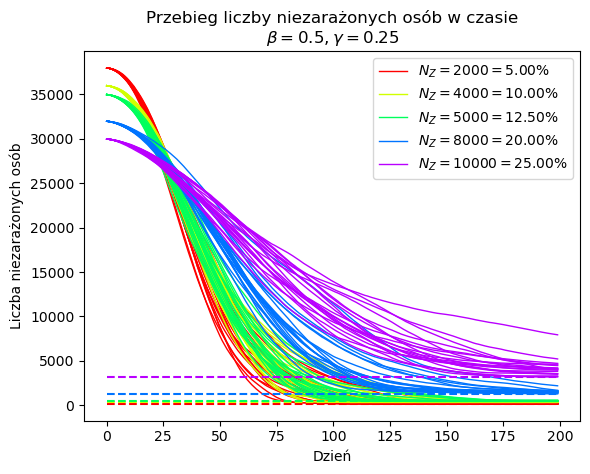

,N_Z,lim
0,2000,148.152
1,4000,312.190
2,5000,424.437
3,8000,1303.019
4,10000,3188.532


In [257]:
import pandas as pd

labels = [
    f"$N_Z={injected_n} = {injected_n/N*100:.2f}\%$" for injected_n in injected_ns
]
show_sequences(
    [result.susceptible for result in results],
    labels,
    title=f"Przebieg liczby niezarażonych osób w czasie\n$\\beta={BETA}, \\gamma={GAMMA}$",
    ylabel="Liczba niezarażonych osób",
)

lims = [result.susceptible.lim_percentile(0.05) for result in results]

pd.DataFrame({"N_Z": injected_ns, "lim": lims})

W okolicach ok. $20\%$ zaszczepionych osób na start, epidemia zaczyna nie dosięgać całej populacji przy ustalonych parametrach $\beta$ i $\gamma$.

Z tego wynika, że jeżeli jedyne co chcemy osiągnąć to minimalizować łączną liczbę zarażonych osób, to szczepienie mniej niż $20\%$ populacji praktycznie nie daje rezultatu i nie ma sensu.

### Wpływ parametru $\beta$ na graniczne $N_Z$

In [248]:
GAMMA = 0.25
INJECTED_N = 8000

betas = [0.3, 0.4, 0.5, 0.6, 0.7]

results = [
    run_experiment(
        side=SIDE,
        infectious_n=INFECTIOUS_N,
        injected_n=INJECTED_N,
        beta=beta,
        gamma=GAMMA,
        experiment_n=EXPERIMENT_N,
        day_n=DAY_N,
    )
    for beta in betas
]

temporary directory: /tmp/tmpg4cp4glg
Eksperyment 1/20
Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/20
Eksperyment 18/20
Eksperyment 19/20
Eksperyment 20/20


Podsumowanie ostatniego z 20 eksperymentów Monte Carlo
  Szczyt zachorowań przypada na dzień 22
  Liczba zarażonych w szczycie to 199 (0% populacji)
  Liczba zarażonych przekraczała 5% populacji przez 0 dni
  Liczba zarażonych utrzymuje się poniżej 5% populacji od dnia 200
temporary directory: /tmp/tmp2t6i0z23
Eksperyment 1/20
Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/20


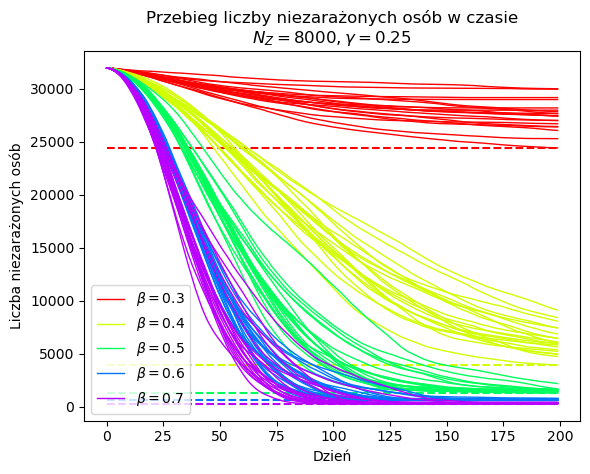

,beta,lim
0,0.3,24437.284
1,0.4,3937.657
2,0.5,1303.019
3,0.6,594.019
4,0.7,262.057


In [249]:
labels = [
    f"$\\beta={beta}$" for beta in betas
]
show_sequences(
    [result.susceptible for result in results],
    labels,
    title=f"Przebieg liczby niezarażonych osób w czasie\n$N_Z={INJECTED_N}, \\gamma={GAMMA}$",
    ylabel="Liczba niezarażonych osób",
)

lims = [result.susceptible.lim_percentile(0.05) for result in results]

pd.DataFrame({"beta": betas, "lim": lims})

Przebieg dość drastycznie się zmienia podczas manipulacji parametrem $\beta$. Zgodnie z intuicją, im większy tym niżej znajduje się wartość graniczna przebiegu i vice versa.

Przy okazji na wykresie widać, że gdy parametr $\beta$ jest bardzo bliski $\gamma$, to epidemia słabo się rozprzestrzenia. Ma to sens - jeśli szansa na wyleczenie jest tylko trochę mniejsza niż szansa na zarażenie, to epidemia ma szanse się zdławić na samym początku, a nawet jeśli nie, to jej rozprzestrzenianie będzie bardzo powolne.

Sprawdźmy, dla jakiej wartości $N_Z$ eksperyment przy $\beta = 0.7$ nie zakończy się zarażeniem całej populacji.

In [250]:
BETA = 0.7
GAMMA = 0.25

injected_ns = [N // 8, N // 5, N // 4, N * 3 // 10, N // 3]

results = [
    run_experiment(
        side=SIDE,
        infectious_n=INFECTIOUS_N,
        injected_n=injected_n,
        beta=BETA,
        gamma=GAMMA,
        experiment_n=EXPERIMENT_N,
        day_n=DAY_N,
    )
    for injected_n in injected_ns
]

temporary directory: /tmp/tmpuvof21us
Eksperyment 1/20
Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/20
Eksperyment 18/20
Eksperyment 19/20
Eksperyment 20/20


Podsumowanie ostatniego z 20 eksperymentów Monte Carlo
  Szczyt zachorowań przypada na dzień 29
  Liczba zarażonych w szczycie to 3288 (8% populacji)
  Liczba zarażonych przekraczała 5% populacji przez 38 dni
  Liczba zarażonych utrzymuje się poniżej 5% populacji od dnia 147
temporary directory: /tmp/tmp2rndb16u
Eksperyment 1/20
Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/2

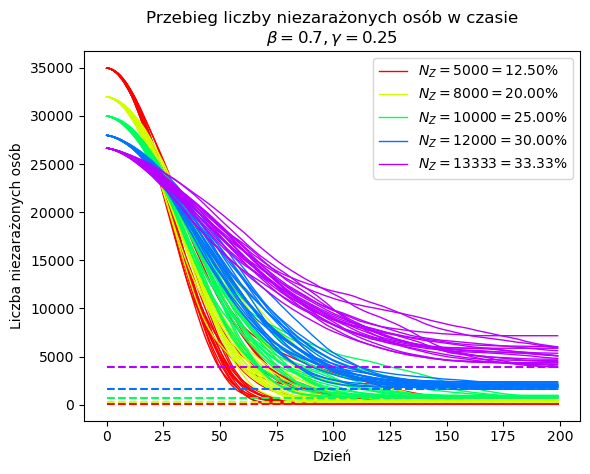

,N_Z,lim
0,5000,76.0095
1,8000,262.0570
2,10000,695.0380
3,12000,1598.3705
4,13333,3872.2755


In [251]:
labels = [
    f"$N_Z={injected_n} = {injected_n/N*100:.2f}\%$" for injected_n in injected_ns
]
show_sequences(
    [result.susceptible for result in results],
    labels,
    title=f"Przebieg liczby niezarażonych osób w czasie\n$\\beta={BETA}, \\gamma={GAMMA}$",
    ylabel="Liczba niezarażonych osób",
)

lims = [result.susceptible.lim_percentile(0.05) for result in results]

pd.DataFrame({"N_Z": injected_ns, "lim": lims})

Tym razem wartość graniczna to ok. $30\%$ populacji. Logiczne - przy większej zaraźliwości choroby potrzeba więcej zaszczepionch osób do zatrzymania epidemii.

### Wpływ parametru $\gamma$ na graniczne $N_Z$

In [252]:
BETA = 0.5
INJECTED_N = 8000

gammas = [0.05, 0.15, 0.25, 0.35, 0.45]

results = [
    run_experiment(
        side=SIDE,
        infectious_n=INFECTIOUS_N,
        injected_n=INJECTED_N,
        beta=BETA,
        gamma=gamma,
        experiment_n=EXPERIMENT_N,
        day_n=DAY_N,
    )
    for gamma in gammas
]

temporary directory: /tmp/tmp0esvl2r0
Eksperyment 1/20
Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/20
Eksperyment 18/20
Eksperyment 19/20
Eksperyment 20/20


Podsumowanie ostatniego z 20 eksperymentów Monte Carlo
  Szczyt zachorowań przypada na dzień 56
  Liczba zarażonych w szczycie to 9035 (22% populacji)
  Liczba zarażonych przekraczała 5% populacji przez 100 dni
  Liczba zarażonych utrzymuje się poniżej 5% populacji od dnia 85
temporary directory: /tmp/tmpogfva3kr
Eksperyment 1/20
Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/

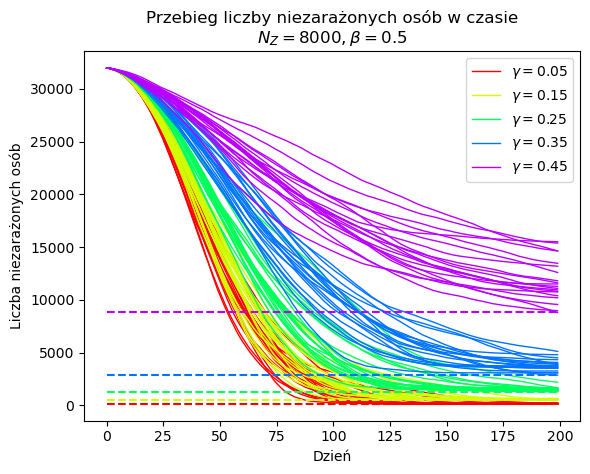

,gamma,lim
0,0.05,140.0285
1,0.15,512.1425
2,0.25,1303.0190
3,0.35,2866.9950
4,0.45,8803.6625


In [253]:
labels = [
    f"$\\gamma={gamma}$" for gamma in gammas
]
show_sequences(
    [result.susceptible for result in results],
    labels,
    title=f"Przebieg liczby niezarażonych osób w czasie\n$N_Z={INJECTED_N}, \\beta={BETA}$",
    ylabel="Liczba niezarażonych osób",
)

lims = [result.susceptible.lim_percentile(0.05) for result in results]

pd.DataFrame({"gamma": gammas, "lim": lims})

Parametr $\gamma$ działa odwrotnie niż $\beta$ - jego wzrost powoduje wzrost wartości granicznej osób niezarażonych.

Sprawdźmy, dla jakiej wartości $N_Z$ eksperyment przy $\gamma = 0.05$ nie zakończy się zarażeniem całej populacji.

In [254]:
BETA = 0.5
GAMMA = 0.05

injected_ns = [N // 4, N * 3 // 10, N * 35 // 100, N * 4 // 10]

results = [
    run_experiment(
        side=SIDE,
        infectious_n=INFECTIOUS_N,
        injected_n=injected_n,
        beta=BETA,
        gamma=GAMMA,
        experiment_n=EXPERIMENT_N,
        day_n=DAY_N,
    )
    for injected_n in injected_ns
]

temporary directory: /tmp/tmpqgw49qs0
Eksperyment 1/20
Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/20
Eksperyment 18/20
Eksperyment 19/20
Eksperyment 20/20


Podsumowanie ostatniego z 20 eksperymentów Monte Carlo
  Szczyt zachorowań przypada na dzień 67
  Liczba zarażonych w szczycie to 5090 (12% populacji)
  Liczba zarażonych przekraczała 5% populacji przez 119 dni
  Liczba zarażonych utrzymuje się poniżej 5% populacji od dnia 61
temporary directory: /tmp/tmpy5sz4_ir
Eksperyment 1/20
Eksperyment 2/20
Eksperyment 3/20
Eksperyment 4/20
Eksperyment 5/20
Eksperyment 6/20
Eksperyment 7/20
Eksperyment 8/20
Eksperyment 9/20
Eksperyment 10/20
Eksperyment 11/20
Eksperyment 12/20
Eksperyment 13/20
Eksperyment 14/20
Eksperyment 15/20
Eksperyment 16/20
Eksperyment 17/

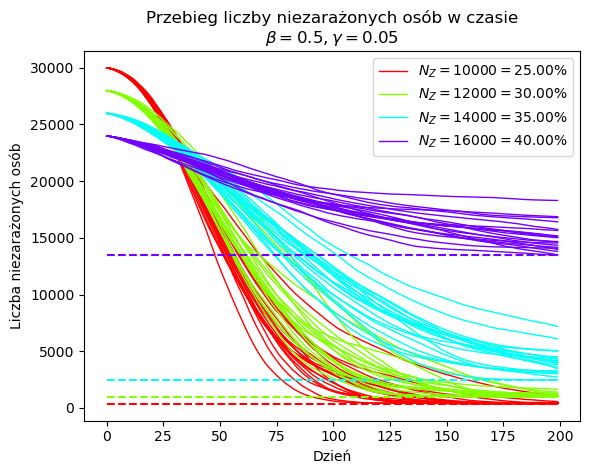

,N_Z,lim
0,10000,358.3325
1,12000,958.5130
2,14000,2491.2705
3,16000,13485.1330


In [255]:
labels = [
    f"$N_Z={injected_n} = {injected_n/N*100:.2f}\%$" for injected_n in injected_ns
]
show_sequences(
    [result.susceptible for result in results],
    labels,
    title=f"Przebieg liczby niezarażonych osób w czasie\n$\\beta={BETA}, \\gamma={GAMMA}$",
    ylabel="Liczba niezarażonych osób",
)

lims = [result.susceptible.lim_percentile(0.05) for result in results]

pd.DataFrame({"N_Z": injected_ns, "lim": lims})

W tym przypadku, wartość graniczna to ok. $35\%$ populacji. Całkiem zaskakujące, bo szansa na wyleczenie to tylko $5\%$, a zatem spadła 5-krotnie od podstawowego przypadku, a potrzebne było ,,tylko'' 75% więcej zaszczepionych osób.

### Ogólne wnioski

Zdaje się, że przy $N_Z$ zbliżającym się do poziomu $40-50\%$, niezależnie od parametrów wirusa zostaje on powstrzymany zanim zarazi całą populację.

Myślę, że może być to własność spowodowana prostotą modelu. Przy takich wartościach $N_Z$ prawdopodobnie tworzą się obszary ,,odcięte'' od wirusa. Ze względu na to, że wirus przenosi się jedynie na bezpośrednich sąsiadów, nie jest on w stanie przedostać się przez ,,ściany'' osób zaszczepionych.

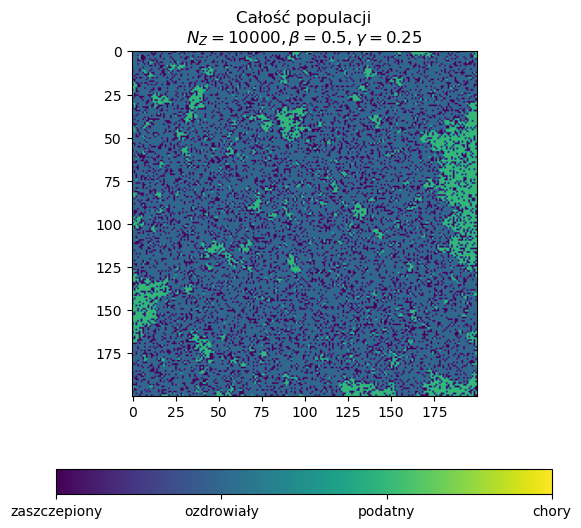

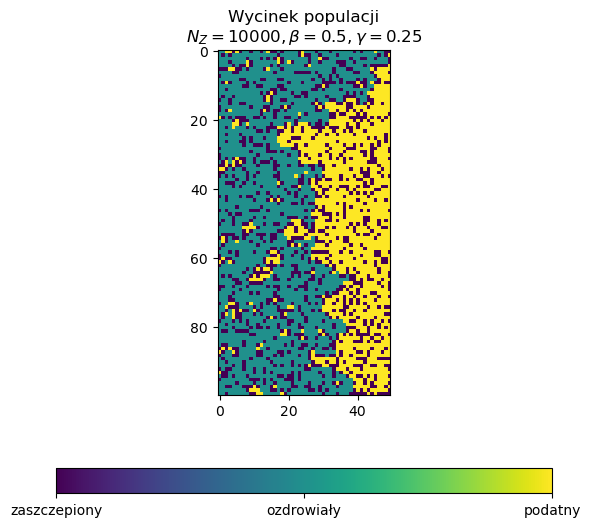

In [268]:
show_map(
    results[-1].final_map,
    title=f"Całość populacji\n$N_Z={injected_ns[-1]}, \\beta={BETA}, \\gamma={GAMMA}$",
)

show_map(
    results[-1].final_map[25:125, 150:],
    title=f"Wycinek populacji\n$N_Z={injected_ns[-1]}, \\beta={BETA}, \\gamma={GAMMA}$",
)

Mapa populacji dla $\gamma = 0.05, \beta = 0.5$ i $N_Z = 40\%$ zdaje się potwierdzać moje przypuszczenie. Można dostrzec, że przez dużą liczbę zaszczepionych osób, wirus miał utrudniony dostęp do wskazanego obszaru. Gdy osobniki na granicy wyzdrowiały, wirus całkowicie stracił szansę na rozprzestrzenienie się we wskazanym obszarze.